## Importando as bibliotecas necessárias

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

## Execução da Tarefa

### Funções Utilizadas

In [225]:
#Funcao simples que mostra uma imagem na tela
def show_img(image):
    plt.figure()
    plt.imshow(image)

#Retorna os dados de uma image(Altura, largura e canais de cores)
def get_data_img(image):
    alt_img = img.shape[0]
    larg_img = img.shape[1]
    can_cor_img = img.shape[2]
    
    return alt_img, larg_img, can_cor_img
    
def show_data_img(altura, largura, canal_cor):
    print("Altura: %.2f" %altura)
    print("Largura: %.2f" %largura)
    print("Canais de cor: %d" %canal_cor)
    

'''
Encontra o valor do limite para ser usado na transformacao de Hough,
dado a quantidade de linhas que quero dentro de uma imagem.
'''
def search_limit(qtd_linhas, imagem):
    limite = 1
    lines = cv2.HoughLines(imagem, 1, np.pi/180, 1)
    while(len(lines) > qtd_linhas):
        limite += 1
        lines = cv2.HoughLines(imagem, 1, np.pi/180, limite)
    
    return limite
    

def transform_hough(qtd_linhas, imagem):
    limite = search_limit(qtd_linhas, imagem)
    lines = cv2.HoughLines(imagem, 1, np.pi/180, limite)
    lines_to_list = list(lines)
    return lines


def get_line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0] * p2[1] - p2[0] * p1[1])
    return A, B, -C

'''
Encontra e mostra as retas de uma imagem.
Encontra e retorna um array de retas. 
'''
def lines_on_img(lines, img):
    L = []
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        
        x0 = a * rho
        y0 = b * rho
        
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        
        L.append(get_line([y1, x1], [y2, x2]))
        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 10)
    show_img(img)
    return L

def intersection(L1, L2):
    D = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    
    if(D != 0):
        x = Dx / D
        y = Dy / D
        
        #Valor invertido
        return y, x
    else:
        return False

def get_pontos_intersec(retas):
    pontos_intersec = []
    for i in range(len(retas)):
        j = i+1;
        while(j < len(retas)):
            ponto = intersection(retas[i], retas[j])
            #print(ponto)
            #Estava vindos pontos a mais, seria pq estava negativo?
            if(ponto and ponto[0] > 0 and ponto[1] > 0):
                pontos_intersec.append(ponto)
                #print(ponto)
            j+=1
    
    #Remodelando para uma lista pontos (NECESSARIO???????????)
    pontos_intersec = np.float32(pontos_intersec)
    return pontos_intersec


#------------Funcoes do artiro de getPerscpective Transform------------#
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    #Multiplicar pela proporcao?
    return rect

def cut_image(rect, img):
    (tr, tl, bl, br) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # ...and now for the height of our new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # construct our destination points which will be used to
    # map the screen to a top-down, "birds eye" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix and warp
    # the perspective to grab the screen
    M = cv2.getPerspectiveTransform(rect, dst)
    warp = cv2.warpPerspective(img, M, (maxWidth, maxHeight))
    show_img(warp)

### Aplicando operações mortfólogicas para ter uma imagem mais limpa ao localizar as bordas

In [236]:
def limpa_imagem_oper_morfol(image, kernel_values,inv_cor=False,opn=False,close=False,dilat=False,eros=False):
    #image = cv2.imread(caminho_imagem)
    #Transformando a imagem em escala de cinza
    gray_scale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #Inverter a cor, se necessario
    if(inv_cor):
        gray_scale_image = cv2.bitwise_not(gray_scale_image)
        
    #Revelando regioes mais escuras (ou seja, os digitos) do que a regiao claras (o fundo)
    thresh = cv2.threshold(gray_scale_image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    #Limpando a imagem com operações morfologicas (Abertura e fechamento)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_values)
    
    #Consultado em:
    #https://bityli.com/z6LQnF (Link encurtado -> Transformacoes morfologicas)
    if(opn):
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    if(close):
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    if(eros):
        thresh = cv2.erode(thresh, kernel)
    if(dilat):
        thresh = cv2.dilate(thresh, kernel)
    

    return thresh

## Primeira base de testes

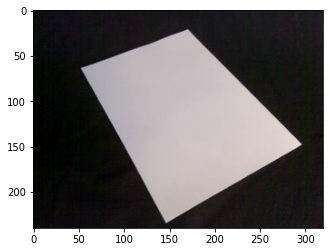

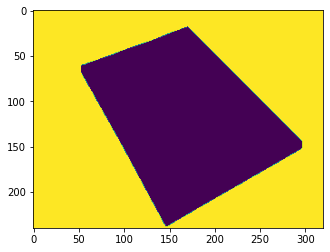

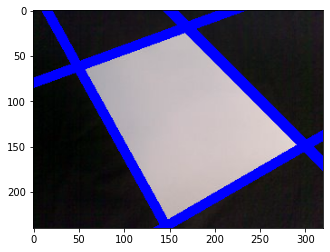

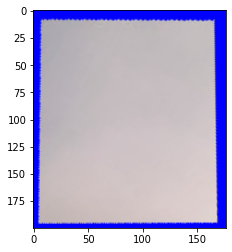

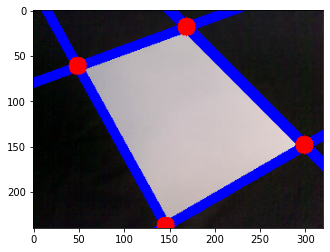

In [226]:
##EXECUTA OS PASSOS
def exec_base1_img_1():
    imagem_base = "base1/001.jpg"
    img = cv2.imread(imagem_base)
    show_img(img)
    
    #Alterando a img para escala de cinza e aplicando operacoes morfologicas
    #(image, kernel_values,inv_cor=False,opn=False,close=False,dilat=False,eros=False):
    clean_image = limpa_imagem_oper_morfol(img, (1,8), inv_cor=False, opn=False,close=False,dilat=False,eros=True)
    show_img(clean_image)
    
    #Encontrando as bordas
    vc_1 = 5
    vc_2 = 150
    aS = 3
    
    #Localiza as bordas
    bordas_img = cv2.Canny(clean_image, vc_1, vc_2, apertureSize=aS)
    lines_img = transform_hough(4, bordas_img)
    retas = lines_on_img(lines_img, img)
    
    #Localiza as intersecoes
    intersecoes = get_pontos_intersec(retas)
    
    #Ordena os pontos das intersecoes
    pontos = order_points(intersecoes)
    (a, b, c, d) = pontos
    
    #Recortando a imagem
    cut_image(pontos, img)
    
    #Apenas mostrando os pontos de intersecoes
    image_points = cv2.circle(img, (int(a[0]), int(a[1])), radius=10, color=(255, 0, 0), thickness=-1)
    image_points = cv2.circle(img, (int(b[0]), int(b[1])), radius=10, color=(255, 0, 0), thickness=-1)
    image_points = cv2.circle(img, (int(c[0]), int(c[1])), radius=10, color=(255, 0, 0), thickness=-1)
    image_points = cv2.circle(img, (int(d[0]), int(d[1])), radius=10, color=(255, 0, 0), thickness=-1)
    show_img(image_points)

exec_base1_img_1()


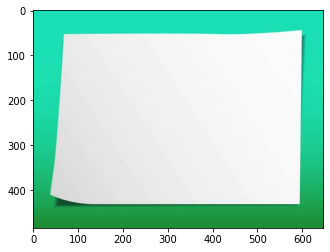

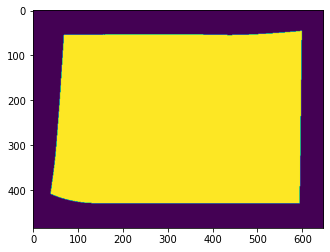

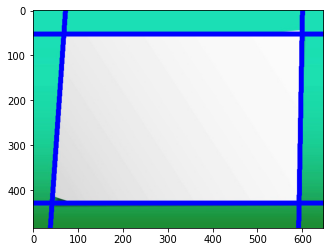

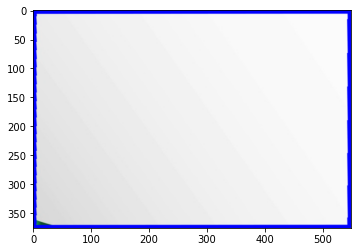

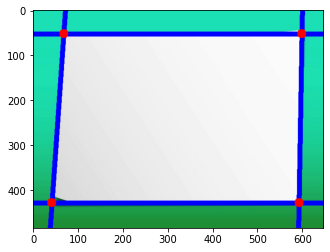

In [227]:
def exec_base1_img_3():
    imagem_base = "base1/003.jpg"
    img = cv2.imread(imagem_base)
    show_img(img)
    
    #Alterando a img para escala de cinza e aplicando operacoes morfologicas
    #(image, kernel_values,inv_cor=False,opn=False,close=False,dilat=False,eros=False):
    clean_image = limpa_imagem_oper_morfol(img, (1,5), inv_cor=True, opn=False,close=True,dilat=False,eros=True)
    show_img(clean_image)
    
    #Encontrando as bordas
    vc_1 = 5
    vc_2 = 150
    aS = 3
    
    #Localiza as bordas
    bordas_img = cv2.Canny(clean_image, vc_1, vc_2, apertureSize=aS)
    lines_img = transform_hough(4, bordas_img)
    retas = lines_on_img(lines_img, img)
    
    #Localiza as intersecoes
    intersecoes = get_pontos_intersec(retas)
    
    #Ordena os pontos das intersecoes
    pontos = order_points(intersecoes)
    (a, b, c, d) = pontos
    
    #Recortando a imagem
    cut_image(pontos, img)
    
    #Apenas mostrando os pontos de intersecoes
    image_points = cv2.circle(img, (int(a[0]), int(a[1])), radius=10, color=(255, 0, 0), thickness=-1)
    image_points = cv2.circle(img, (int(b[0]), int(b[1])), radius=10, color=(255, 0, 0), thickness=-1)
    image_points = cv2.circle(img, (int(c[0]), int(c[1])), radius=10, color=(255, 0, 0), thickness=-1)
    image_points = cv2.circle(img, (int(d[0]), int(d[1])), radius=10, color=(255, 0, 0), thickness=-1)
    show_img(image_points)

exec_base1_img_3()


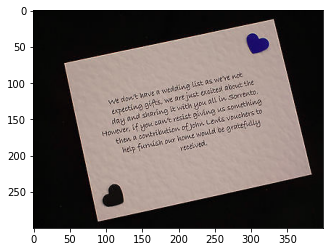

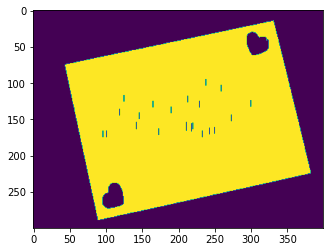

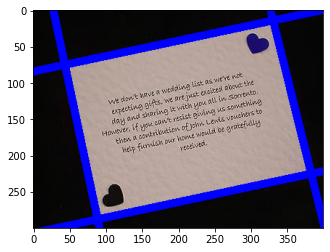

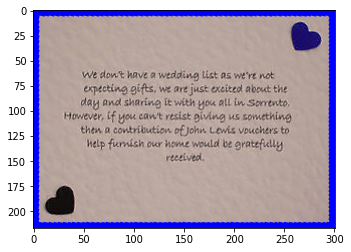

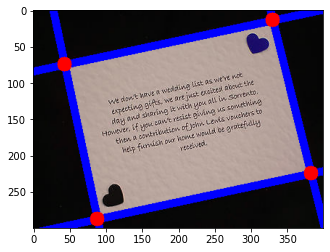

In [229]:
def exec_base1_img_4():
    imagem_base = "base1/004.jpg"
    img = cv2.imread(imagem_base)
    show_img(img)
    
    #Alterando a img para escala de cinza e aplicando operacoes morfologicas
    #(image, kernel_values,inv_cor=False,opn=False,close=False,dilat=False,eros=False):
    clean_image = limpa_imagem_oper_morfol(img, (1,5), inv_cor=True, opn=False,close=True,dilat=False,eros=True)
    show_img(clean_image)
    
    #Encontrando as bordas
    vc_1 = 5
    vc_2 = 150
    aS = 3
    
    #Localiza as bordas
    bordas_img = cv2.Canny(clean_image, vc_1, vc_2, apertureSize=aS)
    lines_img = transform_hough(4, bordas_img)
    retas = lines_on_img(lines_img, img)
    
    #Localiza as intersecoes
    intersecoes = get_pontos_intersec(retas)
    
    #Ordena os pontos das intersecoes
    pontos = order_points(intersecoes)
    (a, b, c, d) = pontos
    
    #Recortando a imagem
    cut_image(pontos, img)
    
    #Apenas mostrando os pontos de intersecoes
    image_points = cv2.circle(img, (int(a[0]), int(a[1])), radius=10, color=(255, 0, 0), thickness=-1)
    image_points = cv2.circle(img, (int(b[0]), int(b[1])), radius=10, color=(255, 0, 0), thickness=-1)
    image_points = cv2.circle(img, (int(c[0]), int(c[1])), radius=10, color=(255, 0, 0), thickness=-1)
    image_points = cv2.circle(img, (int(d[0]), int(d[1])), radius=10, color=(255, 0, 0), thickness=-1)
    show_img(image_points)

exec_base1_img_4()


## Segunda base de testes

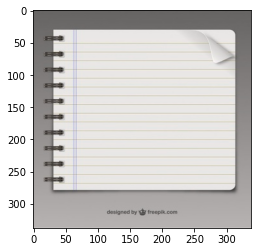

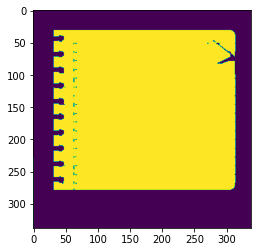

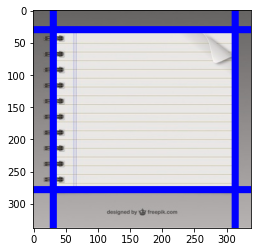

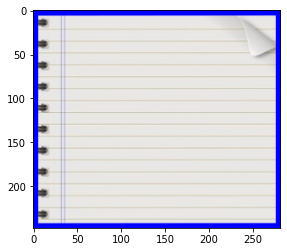

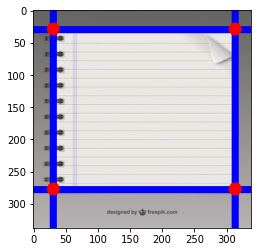

In [231]:
def exec_base2_img_c():
    imagem_base = "base2/base2c.jpg"
    img = cv2.imread(imagem_base)
    show_img(img)
    
    #Alterando a img para escala de cinza e aplicando operacoes morfologicas
    #(image, kernel_values,inv_cor=False,opn=False,close=False,dilat=False,eros=False):
    clean_image = limpa_imagem_oper_morfol(img, (1,5), inv_cor=True, opn=True,close=False,dilat=False,eros=False)
    show_img(clean_image)
    
    #Encontrando as bordas
    vc_1 = 5
    vc_2 = 150
    aS = 3
    
    #Localiza as bordas
    bordas_img = cv2.Canny(clean_image, vc_1, vc_2, apertureSize=aS)
    lines_img = transform_hough(4, bordas_img)
    retas = lines_on_img(lines_img, img)
    
    #Localiza as intersecoes
    intersecoes = get_pontos_intersec(retas)
    
    #Ordena os pontos das intersecoes
    pontos = order_points(intersecoes)
    (a, b, c, d) = pontos
    
    #Recortando a imagem
    cut_image(pontos, img)
    
    #Apenas mostrando os pontos de intersecoes
    image_points = cv2.circle(img, (int(a[0]), int(a[1])), radius=10, color=(255, 0, 0), thickness=-1)
    image_points = cv2.circle(img, (int(b[0]), int(b[1])), radius=10, color=(255, 0, 0), thickness=-1)
    image_points = cv2.circle(img, (int(c[0]), int(c[1])), radius=10, color=(255, 0, 0), thickness=-1)
    image_points = cv2.circle(img, (int(d[0]), int(d[1])), radius=10, color=(255, 0, 0), thickness=-1)
    show_img(image_points)

exec_base2_img_c()


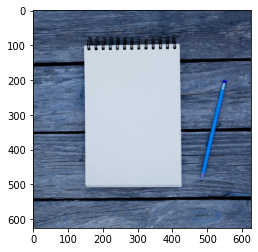

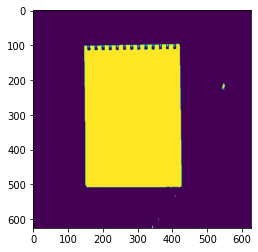

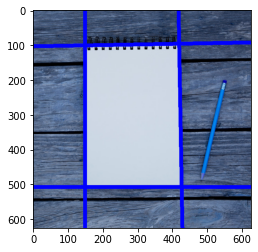

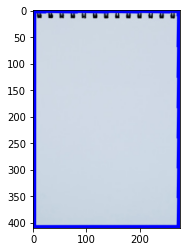

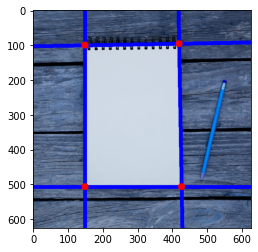

In [232]:
def exec_base2_img_e():
    imagem_base = "base2/base2e.jpg"
    img = cv2.imread(imagem_base)
    show_img(img)
    
    #Alterando a img para escala de cinza e aplicando operacoes morfologicas
    #(image, kernel_values,inv_cor=False,opn=False,close=False,dilat=False,eros=False):
    clean_image = limpa_imagem_oper_morfol(img, (1,5), inv_cor=True, opn=True,close=True,dilat=False,eros=False)
    show_img(clean_image)
    
    #Encontrando as bordas
    vc_1 = 5
    vc_2 = 150
    aS = 3
    
    #Localiza as bordas
    bordas_img = cv2.Canny(clean_image, vc_1, vc_2, apertureSize=aS)
    lines_img = transform_hough(4, bordas_img)
    retas = lines_on_img(lines_img, img)
    
    #Localiza as intersecoes
    intersecoes = get_pontos_intersec(retas)
    
    #Ordena os pontos das intersecoes
    pontos = order_points(intersecoes)
    (a, b, c, d) = pontos
    
    #Recortando a imagem
    cut_image(pontos, img)
    
    #Apenas mostrando os pontos de intersecoes
    image_points = cv2.circle(img, (int(a[0]), int(a[1])), radius=10, color=(255, 0, 0), thickness=-1)
    image_points = cv2.circle(img, (int(b[0]), int(b[1])), radius=10, color=(255, 0, 0), thickness=-1)
    image_points = cv2.circle(img, (int(c[0]), int(c[1])), radius=10, color=(255, 0, 0), thickness=-1)
    image_points = cv2.circle(img, (int(d[0]), int(d[1])), radius=10, color=(255, 0, 0), thickness=-1)
    show_img(image_points)

exec_base2_img_e()


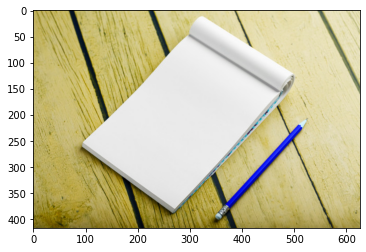

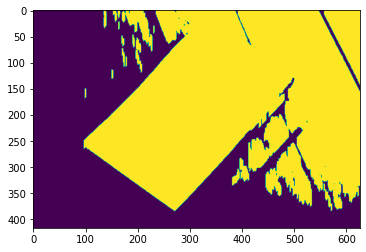

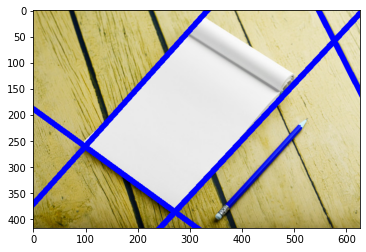

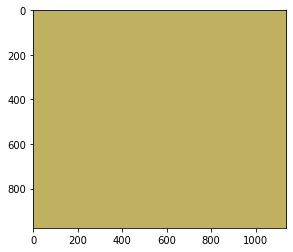

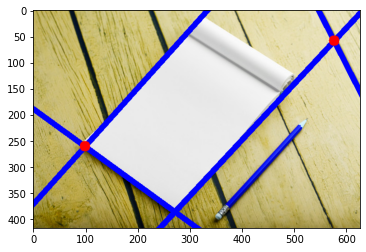

In [234]:
#INCOMPLETO
def exec_base2_img_f():
    imagem_base = "base2/base2f.jpg"
    img = cv2.imread(imagem_base)
    show_img(img)
    
    #Alterando a img para escala de cinza e aplicando operacoes morfologicas
    #(image, kernel_values,inv_cor=False,opn=False,close=False,dilat=False,eros=False):
    clean_image = limpa_imagem_oper_morfol(img, (2,8), inv_cor=True, opn=True,close=False,dilat=True,eros=False)
    show_img(clean_image)
    
    #Encontrando as bordas
    vc_1 = 5
    vc_2 = 150
    aS = 3
    
    #Localiza as bordas
    bordas_img = cv2.Canny(clean_image, vc_1, vc_2, apertureSize=aS)
    lines_img = transform_hough(4, bordas_img)
    retas = lines_on_img(lines_img, img)
    
    #Localiza as intersecoes
    intersecoes = get_pontos_intersec(retas)
    
    #Ordena os pontos das intersecoes
    pontos = order_points(intersecoes)
    (a, b, c, d) = pontos
    
    #Recortando a imagem
    cut_image(pontos, img)
    
    #Apenas mostrando os pontos de intersecoes
    image_points = cv2.circle(img, (int(a[0]), int(a[1])), radius=10, color=(255, 0, 0), thickness=-1)
    image_points = cv2.circle(img, (int(b[0]), int(b[1])), radius=10, color=(255, 0, 0), thickness=-1)
    image_points = cv2.circle(img, (int(c[0]), int(c[1])), radius=10, color=(255, 0, 0), thickness=-1)
    image_points = cv2.circle(img, (int(d[0]), int(d[1])), radius=10, color=(255, 0, 0), thickness=-1)
    show_img(image_points)

exec_base2_img_f()
